# CS 168 Spring Assignment 3

SUNet ID(s): 05794739

Name(s): Luis A. Perez

Collaborators: None

By turning in this assignment, I agree by the Stanford honor code and declare
that all of this is my own work.


# Imports

In [1]:
import collections
import matplotlib.pyplot as plt
import scipy

import numpy as np
import pandas as pd
import seaborn as sns
import os
import warnings

from typing import Dict, List, Text, Tuple

# Make figure larger
plt.rcParams['figure.figsize'] = [10, 5]

# Set numpy seed for consistent results.
np.random.seed(1)

# Part 1

In [2]:
def generate_data():
    """Generates synthetic data for LS problems.
    
    Returns:
        X: A (n,d) matrix where each row is a datapoint, and d is the dimension of thedata.
        y: A (n,1) matrix with the noisy labels for the data.
        a_true: A (d,1) matrix of the true linear coefficients such that Xa = y + noise
    """
    d = 100 # dimensions of data
    n = 1000 # number of data points
    X = np.random.normal(0,1, size=(n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y = X.dot(a_true) + np.random.normal(0,0.5,size=(n,1))

    return X, y, a_true

In [3]:
class Globals:
    X, y, a_true = generate_data()

## Part 1a

In [4]:
def analytical_solution(X, y):
    """Solves LS regression problem analytically."""
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

def cost_funtion(X, y, ahat):
    """Computes the cost function."""
    return np.sum((y - np.dot(X, ahat))**2)

def problem1a():
    a_ls = analytical_solution(Globals.X, Globals.y)
    a_zeros = np.zeros(a_ls.shape)
    
    a_ls_cost = cost_funtion(Globals.X, Globals.y, a_ls)
    a_zeros_cost = cost_funtion(Globals.X, Globals.y, a_zeros)
    
    print("Objective value of LS Solution: {:.2f}".format(a_ls_cost))
    print("Objective value of zero solution: {:.2f}".format(a_zeros_cost))

In [5]:
problem1a()

Objective value of LS Solution: 226.66
Objective value of zero solution: 73311.60


## Part 1b

In [6]:
def gradient(X, y, ahat):
    """Computes the gradient of the cost_function above."""
    return 2 * np.dot(X.T, np.dot(X, ahat) - y)

In [7]:
def initialize_params(d:int):
    """Returns initial parameters to use during gradient descent.
    
    Args:
        d: The dimension of the feature space.
    """
    return np.zeros((d, 1))
    
def gradient_descent(X, y, step_size: float, n_iters: int = 20):
    """Runs gradient descent on data.
    
    Args:
        X, y: The data and labels.
        step_size: Size of step to take in direction of gradients.
        n_iters: Number of iterations of gradient descent.
        
    Returns the parameters after n_iters and a list of n_iters + 1
        elements where costs[i] corresponds to the objective value
        after i iterations.
    """
    _, d = X.shape
    a_hat = initialize_params(d)
    costs = [cost_funtion(X, y, a_hat)]
    for _ in range(n_iters):
        a_hat = (a_hat - step_size * gradient(X, y, a_hat))
        costs.append(cost_funtion(X, y, a_hat))
        
    return costs, a_hat

In [8]:
def plot_training(step_sizes, optimizer, title):
    plt.title("Objective Value after some number of iterations")
    plt.ylabel("Objective Value")
    plt.xlabel("Iteration")
    for step_size in step_sizes:
        costs, _ = optimizer(Globals.X, Globals.y, step_size)
        print("[step_size={}] Objective value: {:.4f}".format(step_size, costs[-1]))
        plt.plot(range(len(costs)), costs, label="step_size=%s" % step_size)

    plt.legend()
    plt.savefig("figures/%s.png" % title, format='png')
    plt.close()

In [9]:
def problem1b():
    plot_training([0.00005, 0.0005, 0.0007], optimizer=gradient_descent, title="gradient_descent_all")
    plot_training([0.00005, 0.0005], optimizer=gradient_descent, title="gradient_descent_converge")

In [10]:
problem1b()

[step_size=5e-05] Objective value: 1531.1249
[step_size=0.0005] Objective value: 226.6593
[step_size=0.0007] Objective value: 1400413723.6268
[step_size=5e-05] Objective value: 1531.1249
[step_size=0.0005] Objective value: 226.6593


## Parb 1c

In [11]:
def norm_error(X, y, a):
    """Computes normalized error."""
    return np.linalg.norm(np.dot(X, a) - y) / np.linalg.norm(y)

In [341]:
def sgd(X, y, step_size: float, n_iters: int = 1000, include_cost:bool=True,
        include_detail=False, X_test=None, y_test=None, initializer=initialize_params,
        gradient=gradient, cost_function=cost_funtion, l2_reg=None, dropout=False):
    """Runs stochastic gradient descent on data.
    
    Args:
        X, y: The data and labels.
        step_size: Size of step to take in direction of gradients.
        n_iters: Number of iterations of gradient descent.
        
    Returns the parameters after n_iters and a list of n_iters + 1
        elements where costs[i] corresponds to the objective value
        after i iterations.
    """
    n, d = X.shape
    a_hat = initializer(d)
    costs = [cost_funtion(X, y, a_hat)] if include_cost else None
    normed_train_error = [norm_error(X, y, a_hat)] if include_detail else None
    normed_test_error = [norm_error(X_test, y_test, a_hat)] if include_detail else None
    l2_norm = [np.linalg.norm(a_hat)] if include_detail else None
    indexes = np.random.randint(0, high=n, size=n_iters)
    for i, idx in enumerate(indexes):
        a_hat = (a_hat - step_size * (gradient(np.take(X, [idx], axis=0), np.take(y, [idx], axis=0), a_hat))
                 + (0 if l2_reg is None else (l2_reg * np.linalg.norm(a_hat))))
        if dropout:
            a_hat = a_hat * np.random.binomial(1,0.1, size=a_hat.shape)
        if include_cost:
            costs.append(cost_funtion(X, y, a_hat))
        if include_detail and i % 100 == 0:
            normed_train_error.append(norm_error(X, y, a_hat))
            normed_test_error.append(norm_error(X_test, y_test, a_hat))
            l2_norm.append(np.linalg.norm(a_hat))
            
    if not include_detail:
        return costs, a_hat
    return costs, a_hat, normed_train_error, normed_test_error, l2_norm

In [13]:
def problem1c():
    plot_training([0.0005,0.005,0.01], optimizer=sgd, title="sgd_all")
    plot_training([0.0005,0.005], optimizer=sgd, title="sgd_converge")

In [14]:
problem1c()

[step_size=0.0005] Objective value: 9267.6573
[step_size=0.005] Objective value: 464.5016
[step_size=0.01] Objective value: 138940.8396
[step_size=0.0005] Objective value: 9967.9908
[step_size=0.005] Objective value: 463.3630


# Part 2

In [15]:
def generate_data_2():
    train_n = 100
    test_n = 1000
    d = 100
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
    
    return X_train, y_train, X_test, y_test, a_true

## Problem 2a

In [186]:
def linear_solver(X, y):
    """Analytical solution for linear regression of square matrix."""
    return np.dot(np.linalg.inv(X), y)

def train_test_error(X_train, y_train, X_test, y_test, a_true, solver):
    """Returns train/test error for simple linear regression."""
    a_hat = solver(X_train, y_train, X_test, y_test)
    train_error = norm_error(X_train, y_train, a_hat)
    train_true_error = norm_error(X_train, y_train, a_true)
    test_error = norm_error(X_test, y_test, a_hat)
    test_true_error = norm_error(X_test, y_test, a_true)
    return train_error, test_error, train_true_error, test_true_error

In [166]:
def avg_train_test_error(n_trials, solver, data=generate_data_2):
    """Using provided solver, run n_trails and report average train/test errors (normalized)."""
    errors = [train_test_error(*data(), solver=solver)
              for _ in range(n_trials)]
    train_errors, test_errors, train_true_errors, test_true_errors = zip(*errors)
    avg_train_error, avg_test_error = np.mean(train_errors), np.mean(test_errors)
    avg_train_true_error, avg_test_true_error = np.mean(train_true_errors), np.mean(test_true_errors)
    return avg_train_error, avg_test_error, avg_train_true_error, avg_test_true_error

In [18]:
def problem2a():
    def local_solver(X, y, X2, y2):
        return linear_solver(X, y)
    train, test, train_true, test_true = avg_train_test_error(n_trials=10, solver=local_solver)
    print("Average normalized train error: {:.4f} compared to true train error: {:.4f}".format(train, train_true))
    print("Average normalized test error: {:.4f} compared to true test error: {:.4f}".format(test, test_true))

In [19]:
problem2a()

Average normalized train error: 0.0000 compared to true train error: 0.0553
Average normalized test error: 1.4199 compared to true test error: 0.0518


## Problem 2b

In [20]:
def l2_regularized_solver(X, y, reg_coeff):
    n, _ = X.shape
    invertible = np.dot(X.T, X) + reg_coeff * np.identity(n)
    return np.dot(np.dot(np.linalg.inv(invertible), X.T), y)

In [21]:
def problem2b():
    errors = []
    coeffs = [0.0005,0.005,0.05,0.5,5,50,500]
    for reg_coeff in coeffs:
        def local_solver(X, y, X2, y2):
            return l2_regularized_solver(X, y, reg_coeff)
        errors.append(avg_train_test_error(n_trials=10, solver=local_solver))
    train, test, _, _ = zip(*errors)
    plt.title("Normalized Train/Test Errors for Different Regularization Coefficients")
    plt.ylabel("Normalized Error")
    plt.xlabel("Regularization Coefficient [Log Scale]")
    plt.xscale('log')
    plt.plot(coeffs, train, label="Train")
    plt.plot(coeffs, test, label="Test")
    plt.legend()
    plt.savefig("figures/train_test_error_l2_reg.png", format='png')
    plt.close()


In [22]:
problem2b()

## Problem 2c

In [23]:
def problem2c():
    for step_size in [0.00005,0.0005,0.005]:
        def sgd_solver(X, y, X_test, y_test):
            _, ahat = sgd(X, y, step_size=step_size, n_iters=int(1e6),
                          include_cost=False, include_detail=False)
            return ahat
        train, test, train_true, test_true = avg_train_test_error(n_trials=10, solver=sgd_solver)
        print("[step_size={}] Train Error: {:.4f}. Test Error: {:.4f}".format(step_size, train, test))
        print("[step_size={}] Train True Error: {:.4f}. Test True Error: {:.4f}".format(step_size, train_true, test_true))

In [24]:
problem2c()

[step_size=5e-05] Train Error: 0.0146. Test Error: 0.2160
[step_size=5e-05] Train True Error: 0.0502. Test True Error: 0.0493
[step_size=0.0005] Train Error: 0.0060. Test Error: 0.2731
[step_size=0.0005] Train True Error: 0.0515. Test True Error: 0.0514
[step_size=0.005] Train Error: 0.0032. Test Error: 0.4221
[step_size=0.005] Train True Error: 0.0477. Test True Error: 0.0521


## Problem 2d

In [25]:
def problem2d():
    for label, step_size in [("small", 0.00005), ("large", 0.005)]:
        normed_train_errors = []
        normed_test_errors = []
        a_norms = []
        n_iters=int(1e6)
        called = False
        def sgd_solver(X, y, X_test, y_test):
            nonlocal normed_train_errors, normed_test_errors, a_norms, called
            assert not called
            _, a_hat, normed_train_errors, normed_test_errors, a_norms = sgd(
                X, y, step_size=step_size, n_iters=n_iters, include_cost=False, include_detail=True,
                X_test=X_test, y_test=y_test)
            called = True
            return a_hat
        train, test, train_true, test_true = avg_train_test_error(n_trials=1, solver=sgd_solver)
        
        # Generate the three plots.
        # Train
        x_ticks = range(0, n_iters + 1, 100)
        plt.title("[step_size=%s] Normalized Training Error over SGD Train" % step_size)
        plt.xlabel("Iteration")
        plt.ylabel("Normalized Training Error")
        plt.plot(x_ticks, normed_train_errors, label="model")
        plt.plot(x_ticks, len(x_ticks) * [train_true], label="ground truth")
        plt.legend()
        plt.savefig("figures/training_error_for_iter_%s.png" % label, format="png")
        plt.close()
        
        # Test
        plt.title("[step_size=%s] Normalized Test Error over SGD Train" % step_size)
        plt.xlabel("Iteration")
        plt.ylabel("Normalized Test Error")
        plt.plot(x_ticks, normed_test_errors, label="model")
        plt.plot(x_ticks, len(x_ticks) * [test_true], label="ground truth")
        plt.legend()
        plt.savefig("figures/test_error_for_iter_%s.png" % label, format="png")
        plt.close()
        
        # Norm.
        plt.title("[step_size=%s] Solution Norm over SGD Train" % step_size)
        plt.xlabel("Iteration")
        plt.ylabel("Norm of Parameters")
        plt.plot(x_ticks, a_norms)
        plt.savefig("figures/solution_norms_for_iter_%s.png" % label, format="png")
        plt.close()

In [26]:
problem2d()

## Problem 2e

In [27]:
def initialize_random_sphere(d: int, r: int):
    """Random point in R^d chosen from r-sphere."""
    random = np.random.normal(size=(d,1))
    unit = random / np.linalg.norm(random)
    return r * unit

In [28]:
def problem2e():
    train_errors, test_errors = [], []
    rs = [0,0.1,0.5,1,10,20,30]
    for r in rs:
        def sgd_solver(X, y, X_test, y_test):
            _, ahat = sgd(X, y, step_size=0.00005, n_iters=int(1e6),
                          include_cost=False, include_detail=False,
                          initializer=lambda d: initialize_random_sphere(d, r))
            return ahat
        train, test, _, _ = avg_train_test_error(n_trials=10, solver=sgd_solver)
        print("[r={}] Train Error: {:.4f}. Test Error: {:.4f}".format(r, train, test))
        train_errors.append(train)
        test_errors.append(test)
    
    plt.title("Normalized Errors for Spherical Initialization")
    plt.xlabel("Sphere Radius [log]")
    plt.xscale('log')
    plt.ylabel("Normalized Error")
    plt.plot(rs, train_errors, label="train")
    plt.plot(rs, test_errors, label="test")
    plt.legend()
    plt.savefig("figures/spherical_initialization_log_x.png", format="png")
    plt.close()

In [29]:
problem2e()

[r=0] Train Error: 0.0149. Test Error: 0.2609
[r=0.1] Train Error: 0.0132. Test Error: 0.2149
[r=0.5] Train Error: 0.0120. Test Error: 0.2432
[r=1] Train Error: 0.0140. Test Error: 0.2324
[r=10] Train Error: 0.0179. Test Error: 0.3057
[r=20] Train Error: 0.0235. Test Error: 0.4453
[r=30] Train Error: 0.0272. Test Error: 0.5626


# Part 3

In [30]:
def generate_data_3():
    train_n = 100
    test_n = 10000
    d = 200
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
    
    return X_train, y_train, X_test, y_test, a_true

## Part 3a

Code below is heavily borrowed from CS230 "Building your deep neural network step by step."

In [31]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [32]:
def L_model_forward(X, Y, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    Y -- labels, numpy array of shape (1, number_of_examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    loss - the loss value after the forward pass.
    AL - final layer activations.
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  
    for l in range(1, L + 1):
        A_prev = A 
        W, b = parameters['W' + str(l)], parameters['b' + str(l)]
        Z = np.dot(W, A) + b
        # Last layer is just linear w/o ReLU
        A = np.maximum(Z, 0) if l < L else Z
        # There are used in the backawards pass for derivative calculations.
        caches.append((Z, A_prev, W))
    
    assert(A.shape == (1,X.shape[1]))
    
    cost = np.mean((A - Y)**2)
            
    return cost, A, caches

In [33]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * L
    
    Arguments:
    AL -- vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward()
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    grads["dA" + str(L)] = 2 * (AL - Y)
    
    # Loop from l=L-1 to l=0
    for l in reversed(range(L)):
        Z, A, W = caches[l]
        dZ = grads["dA" + str(l + 1)]
        if l < L - 1:
            # Final layer is just linear, so all units go through.
            dZ[Z < 0] = 0
        grads["dW" + str(l+1)] = np.dot(dZ, A.T)
        grads["db" + str(l+1)] = np.sum(dZ, axis=1, keepdims=True)
        grads["dA" + str(l)] = np.dot(W.T, dZ)

    return grads

In [53]:
def deep_net_solver(X_train, y_train, X_test, y_test,
                    layer_dims, batch_size, n_epochs, lr=0.001, l2_coeff=0.0):
    """Implement mini-batch SGD.
    
    Args:
        X_train: (f, n) matrix.
        y_train: (1, n) matrix.
        layers_dims: The size of each layer in the networks. 
        batch_size: batches of elements to take for SGD.
        n_epochs: Number of iterations over the dataset to execute.
        lr: learning rate
        l2_coeff: l2_coefficient for regularization.
    """
    f, n = X_train.shape
    batches_per_epoch = n // batch_size + (1 if n % batch_size != 0 else 0)
    parameters = initialize_parameters_deep(layer_dims)
    for epoch in range(n_epochs):
        idxs = np.arange(n)
        np.random.shuffle(idxs)
        X_shuffled = X_train[:, idxs]
        y_shuffled = y_train[:, idxs]
        for i in range(batches_per_epoch):
            X = X_shuffled[:, batch_size * i: batch_size * (i+1) if i + 1 < batches_per_epoch else None]
            y = y_shuffled[:, batch_size * i: batch_size * (i+1) if i + 1 < batches_per_epoch else None]
            _, AL, caches = L_model_forward(X, y, parameters)
            grads = L_model_backward(AL, y, caches)
            
            # Update parameters.
            for name, param in parameters.items():
                parameters[name] = param - lr * (grads["d" + name] + 2 * l2_coeff * param)
    
    
    # Loss on train set.
    _, A_train, _ = L_model_forward(X_train, y_train, parameters)
    _, A_test, _ = L_model_forward(X_train, y_train, parameters)
    print("Training cost: %s" % (np.linalg.norm(A_train - y_train) / np.linalg.norm(y_train)))
    print("Test cost: %s" % (np.linalg.norm(A_test - y_test) / np.linalg.norm(y_test)))
    
    
    return parameters

In [58]:
X_train, y_train, X_test, y_test, a_true = generate_data_3()

In [59]:
_ = deep_net_solver(X_train.T, y_train.T, X_test, y_test,
                    [200, 100, 50, 25, 1], batch_size=4, n_epochs=10000, lr=0.0005, l2_coeff=0.1)

Training cost: 0.054509205348182
Test cost: 13.808224059864854


In [324]:
def problem3a():
    normed_train_errors = []
    normed_test_errors = []
    a_norms = []
    def local_solver(X, y, X_test, y_test):
        nonlocal normed_train_errors, normed_test_errors, a_norms
        costs, a_hat, normed_train_errors, normed_test_errors, a_norms = sgd(
            X, y, step_size=0.0005, n_iters=int(2e4), include_cost=False, include_detail=True,
            X_test=X_test, y_test=y_test)
        return a_hat
    train, test, _, _ = avg_train_test_error(n_trials=200, solver=local_solver, data=generate_data_3)
    return normed_train_errors, normed_test_errors, train, test

In [325]:
trains, tests, train, test = problem3a()

(0.6533873021640614, 0.7046913466247654, 0.7304481961734395, 0.676606555533178, 0.6631997009900906, 0.7241990054471042, 0.7242923378500092, 0.7568729644550134, 0.7525463312468491, 0.7418583365408818, 0.6774669569271765, 0.746698947300382, 0.7353405517664846, 0.6781678301633205, 0.710641587120508, 0.6966500789796182, 0.7438802853671931, 0.6073982830542007, 0.7165762789470205, 0.7591171067630186, 0.7298957968215438, 0.6145952111097347, 0.6881724467715994, 0.7077867623584496, 0.7103710306164417, 0.7265044125803829, 0.6937617576504763, 0.7621143459380745, 0.7094287650106503, 0.7011529810737072, 0.7898608998974475, 0.6963834513864574, 0.6074971960597463, 0.782501129498054, 0.6534571607349144, 0.6721585536842867, 0.7458546535837168, 0.7276222641780249, 0.6929112710433105, 0.6840729686104985, 0.6932931282403231, 0.7789576882538748, 0.7383883764197583, 0.7577507197908104, 0.6926593102341798, 0.7530335110279031, 0.7107214768985397, 0.6851083659753378, 0.718177878761455, 0.7100469159337841, 0.73

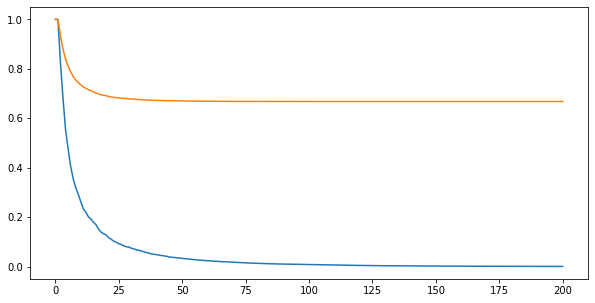

In [326]:
plt.plot(range(len(trains)), trains, label="train")
plt.plot(range(len(tests)), tests, label="test")

In [328]:
print(train), print(test)

0.0008997399081278824
0.7070012887366063


(None, None)

## Problem 3b

In [330]:
def generate_data_3b():
    train_n = 100
    test_n = 10000
    d = 200
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1)) * np.random.binomial(1,0.1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
    
    return X_train, y_train, X_test, y_test, a_true

In [369]:
def problem3b():
    normed_train_errors = []
    normed_test_errors = []
    a_norms = []
    def local_solver(X, y, X_test, y_test):
        nonlocal normed_train_errors, normed_test_errors, a_norms
        costs, a_hat, normed_train_errors, normed_test_errors, a_norms = sgd(
            X, y, step_size=0.0005, n_iters=int(5e3), include_cost=False, include_detail=True,
            X_test=X_test, y_test=y_test, dropout=False)
        return a_hat
    train, test, _, _ = avg_train_test_error(n_trials=200, solver=local_solver, data=generate_data_3b)
    return normed_train_errors, normed_test_errors, train, test

In [370]:
trains, tests, train, test = problem3b()

(0.6889521531729311, 0.7592609066175097, 0.7152098813986446, 0.735791701366354, 0.744841048509771, 0.700294384092639, 0.7673108453983548, 0.6979958935263045, 0.7417776495403703, 0.707691591238198, 0.7767920741935685, 0.7454602600579707, 0.7498708197200745, 0.7371781866161295, 0.7373027017744862, 0.717834174883595, 0.7697338271688782, 0.7373292863032271, 0.7458740171810624, 0.7486022596545512, 0.7473296722610688, 0.6873474625039114, 0.7362349901520022, 0.6905219677483215, 0.7559437832812008, 0.6176188006263585, 0.7261788453530511, 0.7380892672896812, 0.7604766615531466, 0.7193558827821287, 0.6755764719670615, 0.7017658666069554, 0.7619363142242623, 0.7398407644455857, 0.6877607219086274, 0.7530946344389241, 0.7437789342449529, 0.7682305949616455, 0.7313885035717471, 0.6813629182639673, 0.7339322842323146, 0.7136340301416707, 0.6841740692671466, 0.6919685104370668, 0.7226147026511055, 0.7170043969239196, 0.7528159514820484, 0.6963538994163958, 0.706032170407029, 0.6737959683213027, 0.760

In [373]:
test

0.7201104630899533

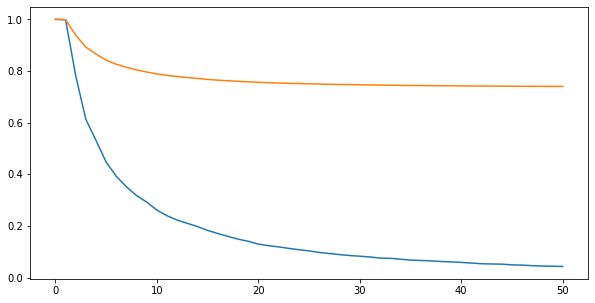

In [372]:
plt.plot(range(len(trains)), trains, label="train")
plt.plot(range(len(tests)), tests, label="test")